## **___Sample Usage___**

In [4]:
import numpy as np
import tqdm
import sys
%matplotlib inline
from sklearn import datasets
from npnn.utils import train, plot, log_csv
from npnn.models import feedforward
from npnn.preprocessing import train_test_split

iris = datasets.load_iris()
X, y = iris.data, iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

  1%|          | 78/10000 [00:00<00:57, 172.27it/s, loss=0.456, train_acc=0.942, val_acc=1]    



Early Stopping at Epoch: 86
Training Finished
Training Accuracy Score: 94.17%
Validation Accuracy Score: 100.00%
Training Curves are saved as a PNG file.
Training Logs are saved as a CSV file.


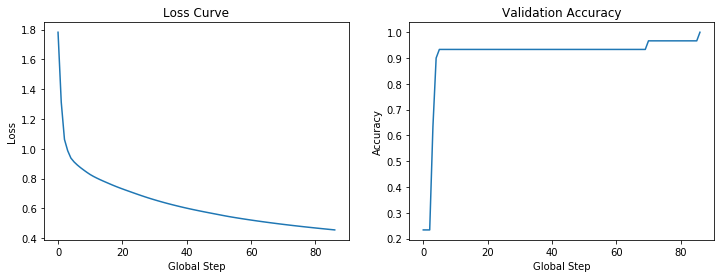

In [5]:
layer_dims = [4, 32, 64, 4]
model_a = feedforward(layer_dims)
model_a = train(model_a, X_train, X_test, y_train, y_test, num_steps=10000)

In [6]:
model_a.keys()

dict_keys(['layer_dims', 'activation', 'learning_rate', 'weight_init', 'dropout_rate', 'var', 'caches', 'losses', 'train_scores', 'val_scores'])

#### Configuring model activation, weight initialization, learning rate, dropout rate

In [7]:
# Store model configs in a dict
model_b_configs = {'layer_dims':[4, 32, 48, 3], # layer dimensions
                   'activation':'relu', # activation function in hidden layer
                   'weight_init':'he_normal', # weight initialization method
                   'dropout_rate':0.5, # (1-keep_prob)
                   'learning_rate':0.003}

  5%|▌         | 512/10000 [00:03<01:01, 153.65it/s, loss=0.428, train_acc=0.908, val_acc=1]    



Early Stopping at Epoch: 513
Training Finished
Training Accuracy Score: 90.83%
Validation Accuracy Score: 100.00%
Training Curves are saved as a PNG file.
Training Logs are saved as a CSV file.


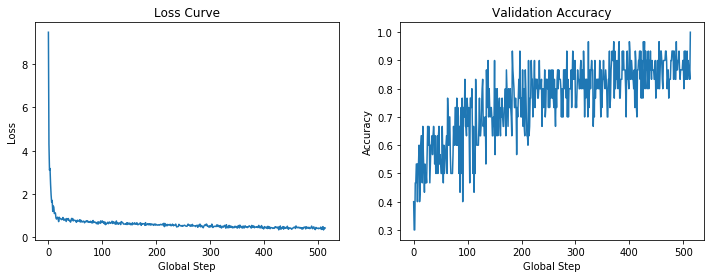

In [8]:
model_b = feedforward(**model_b_configs)
model_b = train(model_b, X_train, X_test, y_train, y_test, num_steps=10000)